In [19]:
import os
import sys
import itertools as itt

from tqdm.auto import tqdm

import napari
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy import ndimage as ndi
from skimage.filters import threshold_li, threshold_minimum, threshold_triangle
from skimage.morphology import remove_small_objects

import numpy as np
import networkx as nx

from pathlib import Path

import pickle

import ccdb
import astromorpho as astro

import graph_utils as gu  
import visualization as vis

import networkx as nx

from networx2napari import draw_edges, draw_nodes

import astro_graph
from astrocyte import Astrocyte
import astrobject as ao

# Параметры для запуска

In [20]:
if os.path.exists('/home/levtg/astro-morpho'):
#     data_dir = '/home/levtg/astro-morpho/data/graphs'
    data_dir = '/home/levtg/astro-morpho/src/output/'
else:
    print("Dont know where to look for the data")

output_dir = './output/'

filename = '4wk-ly9-raw.pic-sequential_graph.pickle' # Octopus

VERBOSE = True

# Set false to start from console
HANDY = True

# Set true to save output
OUT = False

# Оригинальное изображение

In [21]:
full_picture_path = Path('/home/levtg/astro-morpho/data/stacks').joinpath('4wk-ly9-raw.pic')

In [22]:
img, meta = ccdb.read_pic(full_picture_path)
dims = ccdb.get_axes(meta)
zoom = (dims[-1][0]/dims[0][0])

## Кадрирование

In [23]:
def largest_region(mask):
    labels, nlab = ndi.label(mask)
    if nlab > 0:
        objs = ndi.find_objects(labels)
        sizes = [np.sum(labels[o]==k+1) for k,o in enumerate(objs)]
        k = np.argmax(sizes)
        return labels==k+1
    else:
        return mask
        
def crop_image(img, mask=None, margin=0, min_obj_size=0):
    if mask is None:
        mask = img > 0
    if min_obj_size > 0:
        mask = remove_small_objects(mask, min_obj_size)
    if margin > 0:
        mask = ndi.binary_dilation(mask, iterations=margin)
    objs = ndi.find_objects(mask)
    min_bnds = np.min([[sl.start for sl in o] for o in objs],0)
    max_bnds = np.max([[sl.stop for sl in o] for o in objs],0)
    crop = tuple(slice(mn,mx) for mn,mx in zip(min_bnds, max_bnds))
    return img[crop]

In [24]:
max_proj = img.max(0)

domain_mask = ndi.binary_dilation(largest_region(remove_small_objects(max_proj > 0.5*threshold_li(max_proj))), iterations=3)
domain_mask = ndi.binary_closing(domain_mask,iterations=3)

img_cropped = np.array([crop_image(plane,domain_mask, margin=10) for plane in img])
max_proj_1 = img_cropped.max(1)
domain_mask_1 = ndi.binary_dilation(largest_region(remove_small_objects(max_proj_1 > 0.5*threshold_li(max_proj_1))), iterations=3)
domain_mask_1 = ndi.binary_closing(domain_mask_1,iterations=3)

img_cropped = np.array([crop_image(img_cropped[:,i],domain_mask_1, margin=10) for i in range(img_cropped.shape[1])]).swapaxes(0,1)

## Масштабирование

In [11]:
downscale = 2

img_noisy = ndi.zoom(img_cropped.astype(np.float32), (1, 1/downscale, 1/downscale))
scale = (zoom/downscale, 1, 1)

## Фильтрация

In [12]:
def filter_image(image, filter_func):
    threshold = filter_func(image)
    #img_filt = np.where(image > threshold, image, 0)
    pre_mask = ndi.binary_closing(image >= threshold)
    pre_mask = remove_small_objects(pre_mask, 5, connectivity=3)
    binary_clean = largest_region(pre_mask)
    return np.where(binary_clean, image, 0)

In [13]:
img_clear = filter_image(img_noisy, threshold_li)

In [14]:
original_image = img_clear
original_image.shape

(55, 460, 308)

# Чтение обработанных данных

In [25]:
filepath = Path(data_dir).joinpath(filename)
filepath

PosixPath('/home/levtg/astro-morpho/src/output/4wk-ly9-raw.pic-sequential_graph.pickle')

In [26]:
%time file_data = pickle.load(open(filepath, 'rb'))

CPU times: user 33.4 ms, sys: 69.3 ms, total: 103 ms
Wall time: 737 ms


In [27]:
w =  napari.view_image(file_data.image, ndisplay=3, opacity=0.5)
vis.view_graph_as_colored_image(file_data.graph, file_data.parameters['shape'], w);

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [30]:
file_data.image.shape

(55, 464, 312)

In [31]:
from skimage.draw import ellipsoid
from skimage.morphology import erosion

In [33]:
obj = ao.AstrObject(file_data.image)
obj.center_detection()

# Выделение пропорционального эллипсоида

In [34]:
def get_ellipsoid(radius, shape):
    if radius > shape[0]//2:
        raise Exception('Error: radius should be lesser than half of first(minimum) image shape: {}'.format(shape[0]//2))
    a=radius
    b=radius*shape[1]/shape[0]
    c=radius*shape[2]/shape[0]
    ell = ellipsoid(a=a, b=b, c=c)
    sphere = ell ^ erosion(ell)
    return sphere, (a, int(b), int(c))

In [35]:
from copy import copy

In [37]:
test_image = copy(file_data.image)
w = napari.view_image(test_image)
w.add_image(file_data.sigma_mask)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'Image' at 0x7fb9da9da500>

In [38]:
test_image[file_data.sigma_mask > 0] = 0

In [39]:
image = copy(obj.image)
image.shape

(55, 464, 312)

In [40]:
c = obj.center
r = 4
image_shape=tuple(map(lambda pair: min(pair[0]-pair[1], pair[1])*2, zip(obj.image.shape, c)))
sphere, shape = get_ellipsoid(r, image_shape)

In [42]:
image_shape

(40, 300, 258)

In [41]:
shape, sphere.shape

((4, 30, 25), (11, 63, 53))

# Расчет zscore на поверхности 

In [15]:
def down_b(c, r, i):
    return c[i]-r[i]-1

def up_b(c, r, i):
    return c[i]+r[i]+2

In [16]:
img = test_image[down_b(c,shape,0):up_b(c,shape,0), down_b(c,shape,1):up_b(c,shape,1), down_b(c,shape,2):up_b(c,shape,2)]
img.shape
img[~sphere] = 0
napari.view_image(img)

NameError: name 'test_image' is not defined

In [17]:
data = img[sphere]
data.mean(), data.std()
zscore = np.zeros(img.shape)
zscore[sphere] = np.abs(data-data.mean())/data.std()

In [18]:
zscore_old = copy(zscore)
w = napari.view_image(zscore_old)
zscore[zscore>2] = 0
w.add_image(zscore)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'zscore' at 0x7f5b6d3d6e30>

In [19]:
zscore_old.min()

0.0

In [20]:
zscore_bool = np.zeros(zscore.shape, dtype=bool)
zscore_bool[sphere] = (zscore[sphere] > 0) & (img[sphere] > 0)
w.add_image(zscore_bool)

<Image layer 'zscore_bool' at 0x7f5b6d3d69e0>

(array([ 24., 128., 179., 231., 251., 233., 285., 269., 174., 166.]),
 array([ 11.366725,  31.517862,  51.669   ,  71.82014 ,  91.971275,
        112.12241 , 132.27354 , 152.42468 , 172.57582 , 192.72696 ,
        212.8781  ], dtype=float32),
 <BarContainer object of 10 artists>)

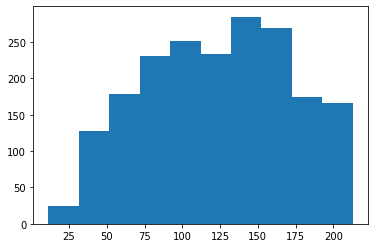

In [21]:
plt.hist(img[zscore_bool])

# Расчет распределения яркости "шубы" на концентрических эллипсоидах

In [15]:
imag

NameError: name 'imag' is not defined

In [22]:
c = obj.center
image_shape=tuple(map(lambda pair: min(pair[0]-pair[1], pair[1])*2, zip(obj.image.shape, c)))
distr = {}
full_distr = {}
w = napari.Viewer()
w.add_image(file_data.image, opacity=0.5)
for r in range(4, 20, 3):
    sphere, shape = get_ellipsoid(r, image_shape)
    img = copy(test_image[down_b(c,shape,0):up_b(c,shape,0), down_b(c,shape,1):up_b(c,shape,1), down_b(c,shape,2):up_b(c,shape,2)])
    img[~sphere] = 0
    zscore = np.zeros(img.shape)
    data = img[sphere]
    full_distr[r] = data
#     data = chosen_data[chosen_data > 0]
    zscore[sphere] = np.abs(data-data.mean())/data.std()
#     print(zscore.max())
    zscore[zscore>2] = 0
#     print(zscore.max())
    zscore_bool = np.zeros(zscore.shape, dtype=bool)
    zscore_bool[sphere] = (zscore[sphere] > 0) & (img[sphere] > 0)
    tmp_image = np.zeros(file_data.image.shape)
    tmp_image[down_b(c,shape,0):up_b(c,shape,0), down_b(c,shape,1):up_b(c,shape,1), down_b(c,shape,2):up_b(c,shape,2)][zscore_bool] = img[zscore_bool]
    w.add_image(tmp_image, colormap='cyan', name='sphere', blending='additive')
#     w.add_image(img)
#     w.add_image(zscore)
    distr[r] = copy(img[zscore_bool])

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


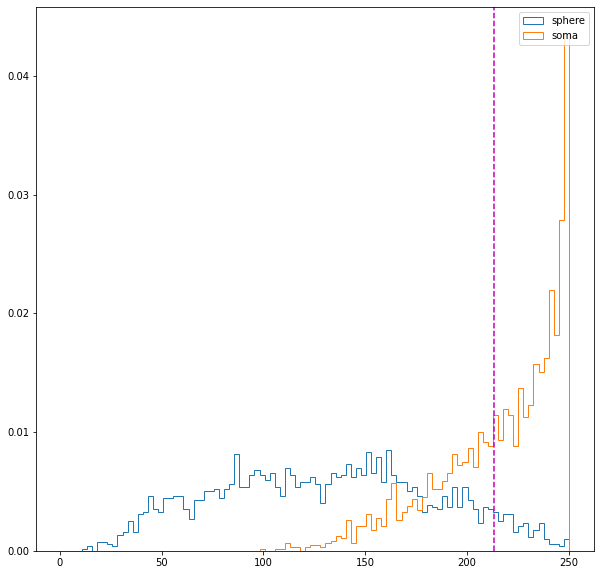

In [23]:
hist_kw = dict(bins=100, histtype='step', density=True,  range=(1,250), log=False)


plt.figure(figsize=(10,10))

data = full_distr[4]

mu = data.mean()

th = mu + 2 * np.std(data)

plt.hist(data,label='sphere', **hist_kw )

# plt.hist(distr[4], label='filtered_sphere', **hist_kw)
#plt.vlines()
plt.hist(file_data.image[file_data.sigma_mask == 8], label='soma', **hist_kw);
plt.axvline(th, color='m', ls='--')

plt.legend()

In [24]:
zscore.max()

1.999927043914795

In [25]:
sphere, shape = get_ellipsoid(r, image_shape)

In [30]:
img = copy(obj.image[down_b(c,shape,0):up_b(c,shape,0), down_b(c,shape,1):up_b(c,shape,1), down_b(c,shape,2):up_b(c,shape,2)])
img[~sphere] = 0
zscore = np.zeros(img.shape)
data = img[sphere]

In [31]:
zscore[sphere] = np.abs(data-data.mean())/data.std()
zscore[zscore>2] = 0
zscore_bool = np.zeros(zscore.shape, dtype=bool)
zscore_bool[sphere] = (zscore[sphere] > 0) & (img[sphere] > 0)

In [33]:
w = napari.view_image(zscore_bool)
w.add_image(zscore)
zscore_ = np.zeros(img.shape)
zscore_[sphere] = np.abs(data-data.mean())/data.std()
w.add_image(zscore_)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'zscore_' at 0x7fca955a3640>

In [ ]:
for 

In [106]:
distr

{3: array([131.17279 , 119.24965 , 121.50922 , 131.83745 , 134.17049 ,
        130.75786 , 134.46602 , 129.72282 , 130.1523  , 112.215034,
        117.58899 , 124.271515, 134.31993 ,  99.29454 , 130.59494 ,
        126.85038 , 130.88875 , 126.84608 , 120.30811 , 107.15181 ,
        111.91774 , 129.70872 ,  88.28433 ,  99.717476, 105.881195,
        132.03905 , 112.16744 ,  65.61734 ,  80.43569 , 130.51543 ,
         64.98054 ,  61.81431 ,  90.41079 ,  77.92778 ,  84.25467 ,
         72.91242 , 109.363594,  75.79258 ,  20.978441,  62.524544,
         62.12514 ,  60.573856,  65.86711 ,  79.87209 , 125.49613 ,
         35.943462,  45.0326  ,  51.714527,  59.424393, 114.04091 ,
        132.64209 ,  42.600536,  56.673733,  47.696033,  71.564575,
         93.8479  ,  75.993225,  52.198963,  75.14858 ,  48.044518,
         20.010416, 128.0147  ,  95.925446,  69.33201 ,  66.40982 ,
        112.766365,  93.91415 ,  52.471348,  44.34956 ,  59.17302 ,
         88.67297 ,  51.10194 ,  68.00493 , 1

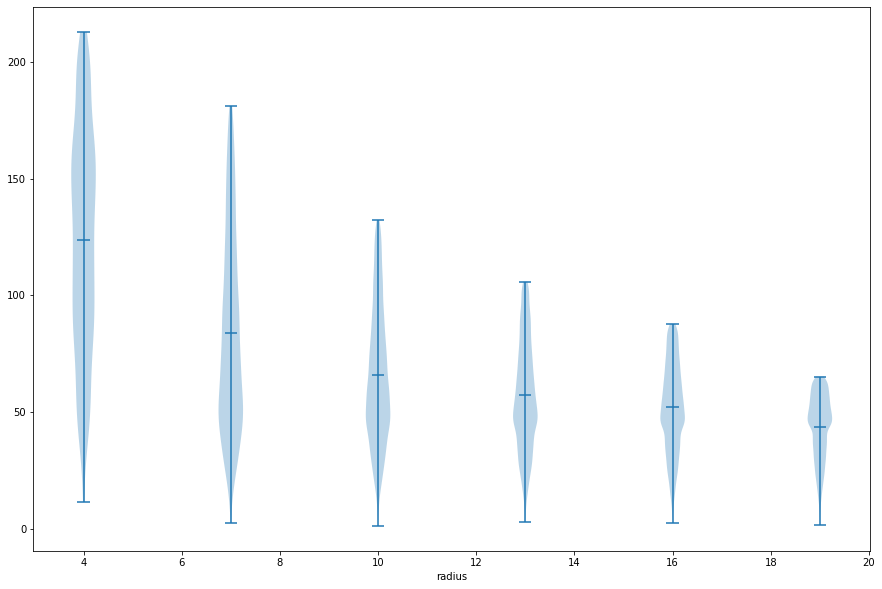

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
ax.violinplot(list(distr.values()), positions=np.arange(4, 20, 3), showmeans=True)

def set_axis_style(ax, labels):
    ax.get_yaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
#     ax.set_yticks(np.arange(1, len(labels) + 1))
#     ax.set_yticklabels(labels)
#     ax.set_ylim(0.25, len(labels) + 0.75)
    ax.set_xlabel('radius')

set_axis_style(ax,list(distr.keys())[::-1])